# TAIAOexp

### Evaluation of explanation quality: saliency maps

Jesús Antoñanzas, under the supervision of Dr. Alvin Jia

<p float="left">
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:300px;"/>
  
  <img src="https://taiao.ai/img/6825_TAIAO_logo_1000x320.jpg" alt="drawing" style="width:250px;"/>
</p>

In this notebook, we are going to explore how we can use TAIAOexp to compare image explanation methods.

## 1. Explaining synthetic image data

In this section, we are going to 
1. Generate image data with available g.t. explanations using the 'seneca' method.
2. Create and train a pytorch classifier that will learn to recognize the pattern in the images.
3. Generate explanations with some model agnostic methods and evaluate them w.r.t. the ground truth explanations.

In [1]:
%cd ../../TAIAOexp/

/home/ajia/TAIAOexp/TAIAOexp


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from math import floor

from saliencyMap import gen_synthetic_imgs

### 1.1. Generating the data

Text(0.5, 1.0, 'Explanation')

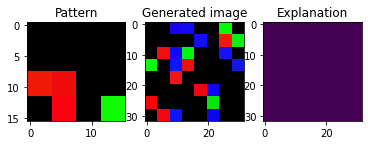

In [3]:
X, y, exps, pat = gen_synthetic_imgs(method='seneca', nSamples=10000, randomState=7)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(pat)
axs[0].set_title('Pattern')
axs[1].imshow(X[0])
axs[1].set_title('Generated image')
axs[2].imshow(exps[0])
axs[2].set_title('Explanation')

### 1.2. Declaring and training the model

Declare a simple LeNet variant and its training routine.

In [4]:
class FCNN(nn.Module):
    """ Basic NN for image classification. """

    def __init__(self, imH, imW, cellH):
        super(FCNN, self).__init__()
        stride = 1
        kSize = 5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=kSize, stride=stride)
        self.H1, self.W1 = floor(((imH - kSize) / stride) + 1), floor(((imW - kSize) / stride) + 1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=kSize, stride=stride)
        self.H2, self.W2 = floor(((self.H1 - kSize) / stride) + 1), floor(((self.W1 - kSize) / stride) + 1)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=kSize, stride=stride)
        self.H3, self.W3 = floor(((self.H2 - kSize) / stride) + 1), floor(((self.W2 - kSize) / stride) + 1)
        self.fc1 = nn.Linear(self.H3 * self.W3, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        if len(x.shape) == 3:
            # single instance, add the batch dimension
            print(x.shape)
            x = x.view(-1, x.shape[2], x.shape[1], x.shape[0])
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.shape[0], -1)))
        x = self.fc2(x)
        return x
    
# sample training function for binary classification
def train_net(model, X, y, XVal, yVal, randomState=888):
    """ X: FloatTensor, y: LongTensor """
    torch.manual_seed(randomState)
    batchSize = 50
    nEpochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bestValAcc = -np.inf
    for epoch in range(nEpochs):
        model.train()
        for batch in range(int(len(X) / batchSize)):
            XBatch = X[batch:batch + batchSize]
            yBatch = y[batch:batch + batchSize]
            model.zero_grad()
            out = model(XBatch)
            loss = criterion(out, yBatch)
            loss.backward()
            optimizer.step()
        model.eval()
        avgLoss = 0
        avgAcc = 0
        for batch in range(int(len(X) / batchSize)):
            XBatch = X[batch:batch + batchSize]
            yBatch = y[batch:batch + batchSize]
            out = model(XBatch)
            loss = criterion(out, yBatch)
            avgLoss += loss.item()
            preds = F.softmax(out, dim=-1).argmax(dim=1)
            acc = accuracy_score(yBatch, preds.detach().numpy())
            avgAcc += acc
        
        avgValLoss = 0
        avgValAcc = 0
        for batch in range(int(len(XVal) / batchSize)):
            XBatch = XVal[batch:batch + batchSize]
            yBatch = yVal[batch:batch + batchSize]
            out = model(XBatch)
            loss = criterion(out, yBatch)
            avgValLoss += loss.item()
            preds = F.softmax(out, dim=-1).argmax(dim=1)
            acc = accuracy_score(yBatch, preds.detach().numpy())
            avgValAcc += acc
        
        avgValAcc /= int(len(XVal) / batchSize)
        avgLoss /= int(len(X) / batchSize)
        avgAcc /= int(len(X) / batchSize)
        
        # early stoppage
        if avgValAcc >= bestValAcc:
            bestValAcc = avgValAcc
        else:
            break

    return model, avgLoss, avgAcc

We cast the images to torch.Tensor type and get train, validation and test splits.

In [5]:
XTrain, XTest, yTrain, yTest, expsTrain, expsTest = train_test_split(X, y, exps, train_size=0.8, random_state=7)
XTrain, XVal, yTrain, yVal, expsTrain, expsVal = train_test_split(XTrain, yTrain, expsTrain, train_size=0.6, random_state=7)

XTrain = torch.FloatTensor(XTrain).permute(0, 3, 1, 2)
yTrain = torch.LongTensor(yTrain)
XVal = torch.FloatTensor(XVal).permute(0, 3, 1, 2)
yVal = torch.LongTensor(yVal)
XTest = torch.FloatTensor(XTest).permute(0, 3, 1, 2)

and train the network

In [6]:
nFeatures = len(XTrain[0].flatten())
model, trLoss, trAcc = train_net(FCNN(imH=32, imW=32, cellH=4), XTrain, yTrain, XVal, yVal, randomState=7)

In [7]:
print(f'Tr. loss: {round(trLoss, 3)}, Tr. accuracy: {round(trAcc, 3)}')
print(f'Validation F1: {round(f1_score(yVal, F.softmax(model(torch.FloatTensor(XVal)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')
print(f'Test F1: {round(f1_score(yTest, F.softmax(model(torch.FloatTensor(XTest)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')

Tr. loss: 0.019, Tr. accuracy: 0.997
Validation F1: 0.752
Test F1: 0.758


### 1.3. Generating and evaluating explanations

With the model trained on the synthetic images, we generate explanations. Althogh not its primary intent, TAIAOexp contains an util to generate Captum explanations. Feel free to use whatever library you may like.

In [8]:
from explanation.images import torch_pixel_attributions

# takes a few minutes to run
gradShapExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='gradientShap')
intGradExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='integratedGradient')
deepLiftExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='deepLift')
occlusionExpsTrain = torch_pixel_attributions(model, XTrain[yTrain == 1], yTrain[yTrain == 1], method='occlusion', sliding_window_shapes=(3, cellH, cellW))

ModuleNotFoundError: No module named '_utils'